  * This notebook was made to look at a big picture of surface currents in the plume area with CODAR data, aiming to get some insights of the currents besides line or point comparison.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
import scipy.io as sio
import os
import matplotlib.colors as mcolors
import seaborn as sns
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from __future__ import division

In [2]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')

In [3]:
## load data
codar = sio.loadmat('/ocean/jieliu/research/meopar/salinity_comparison/SoG_radar_totals.mat')
t = codar['mtime']
lat = codar['glat']
lon = codar['glon']
u = codar['u']
v = codar['v']

In [4]:
run_time = datetime.datetime(2014, 10, 8, 0)

In [5]:
from datetime import timedelta
def python_time(run_time):
    for i,tt  in enumerate(np.arange(0,len(t))):
        matlab_datenum = np.float(t[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        if (python_datetime == run_time):
            #print (python_datetime)
            return python_datetime, i

In [6]:
def plot_codar(run_time):
    axs[0].clear(); axs[1].clear()
    ##plot codar quiver
    viz_tools.plot_coastline(axs[0], grid, coords = 'map')
    viz_tools.plot_coastline(axs[0], grid, coords = 'map', isobath = 5,color = 'OrangeRed')
    axs[0].plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    
    p, ind = python_time(run_time)
    quiver = axs[0].quiver(lon, lat,u[:,:,ind], v[:,:,ind],pivot='mid',width=0.003, color='black' )
    axs[0].quiverkey(quiver,-123.5,49.3, 1, '1 m/s',
                    coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    lonax = [-123.6,-123]
    latax= [48.8,49.4]   
    axs[0].set_xlim(lonax)
    axs[0].set_ylim(latax)
    axs[0].set_xticks([-123.6, -123.4, -123.2,-123])
    axs[0].set_xticklabels([-123.6, -123.4, -123.2,-123])
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')
    axs[0].set_title('codar surface currents on '+p.strftime('%d-%b-%Y %H:%M'), fontsize = 15)
    ## plot ssh at PA
    directory = '/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/'
    path = os.path.join(directory, 'SalishSea_1h_20141008_20141010_grid_T.nc')
    grid_T = nc.Dataset(path,'r')
    ssh =grid_T.variables['sossheig']
    timesteps = grid_T.variables['time_counter'][:]
    t_t = nc_tools.timestamp(grid_T, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t) 
    start_time = datetime.datetime(2014,10,8,0,0)
    hrs = (run_time-start_time).seconds //3600
    axs[1].plot(tt,ssh[:,466,329],'-k')
    axs[1].plot(tt[hrs-1],ssh[hrs-1, 466, 329],'o',color='tomato',markersize=9)
    axs[1].set_ylabel('Water level (m)')
    axs[1].set_title('Modelled water level at Point Atkinson on '+ p.strftime('%d-%b-%Y %H:%M'),fontsize = 15)
    return quiver

# plot

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


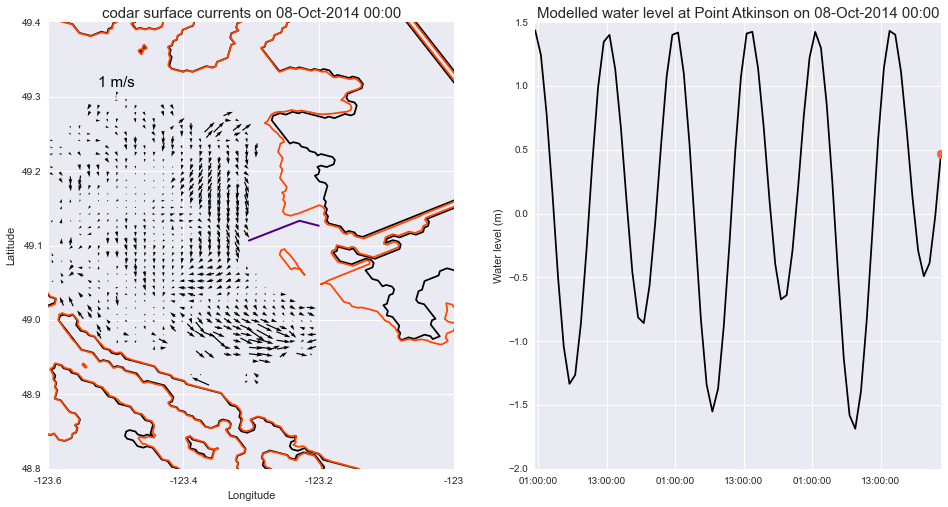

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


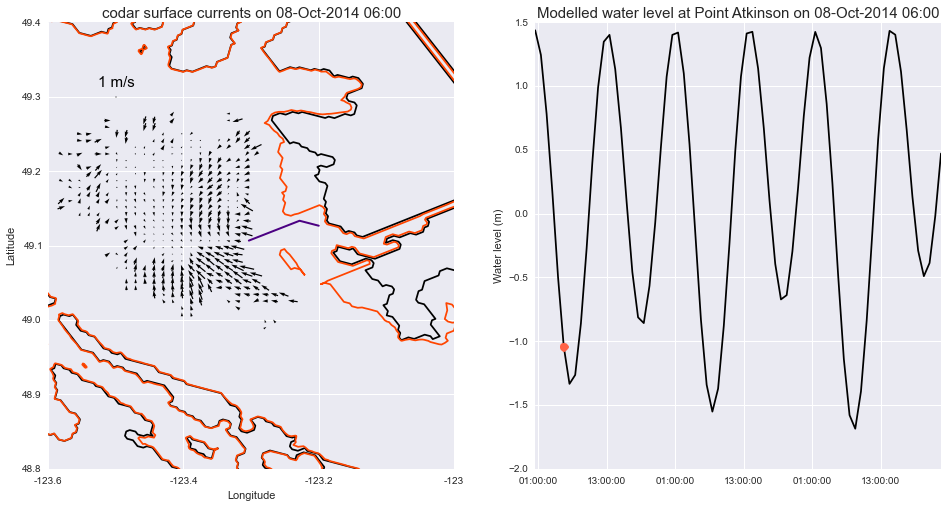

In [8]:
run_time = run_time.replace(hour = 6)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)